In [1]:
import Load_Downsize_SaveAsH5 as cvt

import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


### partial data with Top as target

In [2]:
filePath = './ourdata/'
features = ['j_index','j1_phirel','j1_etarel','j1_phirot','j1_etarot','j1_deltaR','j1_pdgid','j1_pt','j1_ptrel','j1_erel'] 
labels = ['j_g','j_q','j_w','j_z','j_t']
#ratio=[.25,.25,.25,.25,1]
size=10000
seed=42


In [3]:
cvt.LoadTransSave(filePath,features, labels,size=size,seed=seed)

### prepare data

In [3]:
cols = dict(zip(features+['constituents_index'], [i for i in range(len(features)+1)]))

features_list = ['j1_ptrel','j1_etarot','j1_phirot','j1_phirel','j1_etarel','j1_erel','j1_deltaR','j1_pdgid']

def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[],'label':[]}
    f = h5py.File(h5path,'r')
        
    raw_data = np.array([f[col][()] for col in cols])
    label_arr = f['label'][()]
    raw_data = raw_data.transpose((1,0))
    
    mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2)) # prepare constituents list
    for i in range(len(raw_data)):
        cIndex = int(raw_data[i][cols['constituents_index']])
        if cIndex >= 100:                                               # skip when excess 100 particles
            continue
        
        mask[cIndex] = [1]  # no mask for now
            
        points[cIndex] = np.array([raw_data[i][cols['j1_etarel']],raw_data[i][cols['j1_phirel']]])
        features[cIndex] = np.array([raw_data[i][cols[feat]] for feat in features_list])
                
        if i < len(raw_data)-1:
            if raw_data[i][cols['j_index']] != raw_data[i+1][cols['j_index']] : # save the jet before switch to another
                Data['mask'].append(mask)
                Data['points'].append(points)
                Data['features'].append(features)
                Data['label'].append(label_arr[i])
                mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2))  
    f.close()
    y = Data.pop('label')
    return Data, y

def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total

def separatedata(Data,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = Data["mask"]
    features = Data["features"]
    points = Data["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

In [4]:
h5Path = "ourdata/data_10000jets_5labels.h5"
Data,y = h5_to_data(h5Path)
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (100, 1) (100, 2) (100, 8)


In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(Data,y,0.25,0.25)

In [6]:
import sys
sys.path.insert(0,'models')
from tf_keras_model import get_particle_net_lite, get_particle_net

In [7]:
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}
num_classes = 5
model = get_particle_net_lite(num_classes, input_shapes)

In [8]:
batch_size = 1024
epochs = 300

In [9]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 100, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 100, 1)]     0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [10]:
history = model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True)
model.evaluate(X_test,  y_test, verbose=2)

Train on 18465 samples, validate on 9232 samples
Epoch 1/300
18465/18465 [==============================] - 20s 1ms/sample - loss: 1.6803 - accuracy: 0.1962 - val_loss: 1.6139 - val_accuracy: 0.1639
Epoch 2/300
18465/18465 [==============================] - 15s 810us/sample - loss: 1.6026 - accuracy: 0.2237 - val_loss: 1.6070 - val_accuracy: 0.2347
Epoch 3/300
18465/18465 [==============================] - 15s 814us/sample - loss: 1.5609 - accuracy: 0.2655 - val_loss: 1.6050 - val_accuracy: 0.2392
Epoch 4/300
18465/18465 [==============================] - 15s 809us/sample - loss: 1.5261 - accuracy: 0.3150 - val_loss: 1.6048 - val_accuracy: 0.2193
Epoch 5/300
18465/18465 [==============================] - 15s 811us/sample - loss: 1.4916 - accuracy: 0.3633 - val_loss: 1.6048 - val_accuracy: 0.2134
Epoch 6/300
18465/18465 [==============================] - 15s 807us/sample - loss: 1.4560 - accuracy: 0.4091 - val_loss: 1.6070 - val_accuracy: 0.2082
Epoch 7/300
18465/18465 [================

18465/18465 [==============================] - 15s 832us/sample - loss: 0.9169 - accuracy: 0.6540 - val_loss: 0.9223 - val_accuracy: 0.6579
Epoch 55/300
18465/18465 [==============================] - 15s 838us/sample - loss: 0.9123 - accuracy: 0.6561 - val_loss: 0.9203 - val_accuracy: 0.6564
Epoch 56/300
18465/18465 [==============================] - 16s 844us/sample - loss: 0.9072 - accuracy: 0.6587 - val_loss: 0.9173 - val_accuracy: 0.6592
Epoch 57/300
18465/18465 [==============================] - 16s 849us/sample - loss: 0.9081 - accuracy: 0.6577 - val_loss: 0.9157 - val_accuracy: 0.6657
Epoch 58/300
18465/18465 [==============================] - 15s 836us/sample - loss: 0.9053 - accuracy: 0.6616 - val_loss: 0.9136 - val_accuracy: 0.6624
Epoch 59/300
18465/18465 [==============================] - 16s 841us/sample - loss: 0.9031 - accuracy: 0.6622 - val_loss: 0.9114 - val_accuracy: 0.6649
Epoch 60/300
18465/18465 [==============================] - 15s 820us/sample - loss: 0.8997 - a

18465/18465 [==============================] - 15s 838us/sample - loss: 0.8218 - accuracy: 0.7087 - val_loss: 0.8431 - val_accuracy: 0.7031
Epoch 108/300
18465/18465 [==============================] - 16s 845us/sample - loss: 0.8226 - accuracy: 0.7086 - val_loss: 0.8426 - val_accuracy: 0.7028
Epoch 109/300
18465/18465 [==============================] - 16s 840us/sample - loss: 0.8208 - accuracy: 0.7053 - val_loss: 0.8423 - val_accuracy: 0.7052
Epoch 110/300
18465/18465 [==============================] - 15s 824us/sample - loss: 0.8257 - accuracy: 0.7063 - val_loss: 0.8432 - val_accuracy: 0.7045
Epoch 111/300
18465/18465 [==============================] - 15s 836us/sample - loss: 0.8204 - accuracy: 0.7097 - val_loss: 0.8409 - val_accuracy: 0.7057
Epoch 112/300
18465/18465 [==============================] - 16s 843us/sample - loss: 0.8189 - accuracy: 0.7113 - val_loss: 0.8397 - val_accuracy: 0.7084
Epoch 113/300
18465/18465 [==============================] - 15s 827us/sample - loss: 0.81

18465/18465 [==============================] - 15s 823us/sample - loss: 0.7735 - accuracy: 0.7272 - val_loss: 0.8064 - val_accuracy: 0.7204
Epoch 161/300
18465/18465 [==============================] - 15s 832us/sample - loss: 0.7754 - accuracy: 0.7260 - val_loss: 0.8098 - val_accuracy: 0.7159
Epoch 162/300
18465/18465 [==============================] - 15s 813us/sample - loss: 0.7706 - accuracy: 0.7298 - val_loss: 0.8059 - val_accuracy: 0.7204
Epoch 163/300
18465/18465 [==============================] - 15s 815us/sample - loss: 0.7702 - accuracy: 0.7294 - val_loss: 0.8093 - val_accuracy: 0.7173
Epoch 164/300
18465/18465 [==============================] - 15s 814us/sample - loss: 0.7710 - accuracy: 0.7282 - val_loss: 0.8049 - val_accuracy: 0.7217
Epoch 165/300
18465/18465 [==============================] - 15s 815us/sample - loss: 0.7703 - accuracy: 0.7315 - val_loss: 0.8038 - val_accuracy: 0.7206
Epoch 166/300
18465/18465 [==============================] - 15s 814us/sample - loss: 0.77

18465/18465 [==============================] - 15s 832us/sample - loss: 0.7408 - accuracy: 0.7432 - val_loss: 0.7865 - val_accuracy: 0.7310
Epoch 214/300
18465/18465 [==============================] - 16s 856us/sample - loss: 0.7491 - accuracy: 0.7357 - val_loss: 0.7935 - val_accuracy: 0.7238
Epoch 215/300
18465/18465 [==============================] - 16s 855us/sample - loss: 0.7450 - accuracy: 0.7399 - val_loss: 0.7842 - val_accuracy: 0.7333
Epoch 216/300
18465/18465 [==============================] - 16s 856us/sample - loss: 0.7440 - accuracy: 0.7380 - val_loss: 0.7844 - val_accuracy: 0.7331
Epoch 217/300
18465/18465 [==============================] - 16s 857us/sample - loss: 0.7372 - accuracy: 0.7428 - val_loss: 0.7846 - val_accuracy: 0.7301
Epoch 218/300
18465/18465 [==============================] - 15s 814us/sample - loss: 0.7387 - accuracy: 0.7408 - val_loss: 0.7824 - val_accuracy: 0.7325
Epoch 219/300
18465/18465 [==============================] - 15s 812us/sample - loss: 0.74

18465/18465 [==============================] - 15s 785us/sample - loss: 0.7229 - accuracy: 0.7488 - val_loss: 0.7707 - val_accuracy: 0.7373
Epoch 267/300
18465/18465 [==============================] - 15s 800us/sample - loss: 0.7200 - accuracy: 0.7490 - val_loss: 0.7822 - val_accuracy: 0.7303
Epoch 268/300
18465/18465 [==============================] - 15s 785us/sample - loss: 0.7257 - accuracy: 0.7462 - val_loss: 0.7742 - val_accuracy: 0.7366
Epoch 269/300
18465/18465 [==============================] - 15s 796us/sample - loss: 0.7200 - accuracy: 0.7497 - val_loss: 0.7723 - val_accuracy: 0.7365
Epoch 270/300
18465/18465 [==============================] - 15s 792us/sample - loss: 0.7181 - accuracy: 0.7494 - val_loss: 0.7748 - val_accuracy: 0.7343
Epoch 271/300
18465/18465 [==============================] - 15s 786us/sample - loss: 0.7192 - accuracy: 0.7506 - val_loss: 0.7706 - val_accuracy: 0.7368
Epoch 272/300
18465/18465 [==============================] - 15s 836us/sample - loss: 0.71

[0.7566170048787279, 0.73865485]

Text(0.25, 0.9, 'Particle_lite')

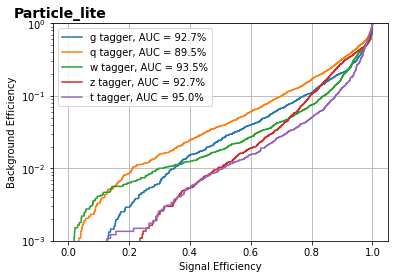

In [11]:
predict_test = model.predict(X_test)
predict_test = predict_test.transpose((1,0))
y_test = y_test.transpose((1,0))
labels = ['g','q','w','z','t']
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[i]
    df[label + '_pred'] = predict_test[i]
    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
    auc1[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend(loc='upper left')
plt.ylim(0.001,1)
plt.grid(True)

plt.figtext(0.25, 0.90,'Particle_lite',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

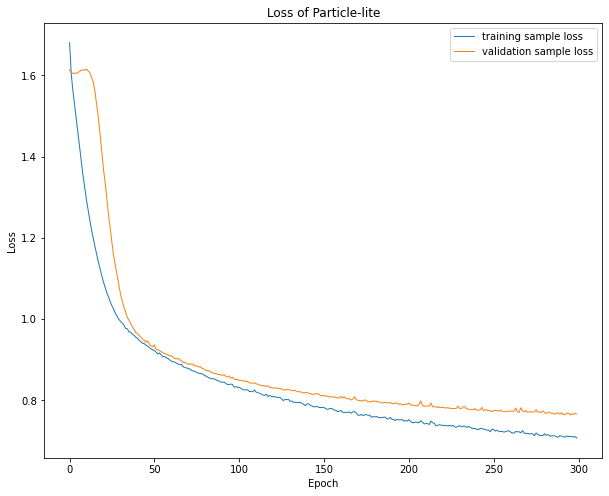

In [12]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Loss of Particle-lite')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
plt.show()
plt.close()

In [13]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'particle net ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

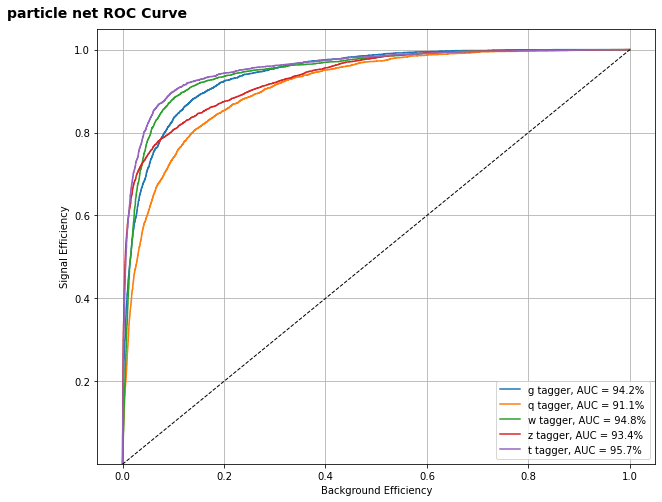

In [14]:
y_pred = makeRoc(X_train, y_train,labels, model, outputSuffix='particle net')